# PyTorch Computer Vision

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.7 MB/s eta 0:00:00


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
test = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform=None
)
train = torchvision.datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11345641.08it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198092.73it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3771752.89it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7204630.29it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
features = train.classes
NUM_OF_CLASSES = len(features)
def plot_object(img: torch.Tensor, title: int):
  plt.imshow(img.squeeze())
  plt.title(features[title])
  plt.axis(False)
  plt.show()

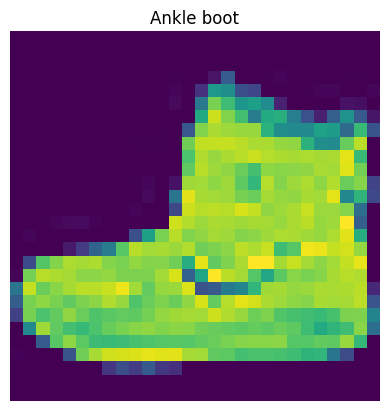

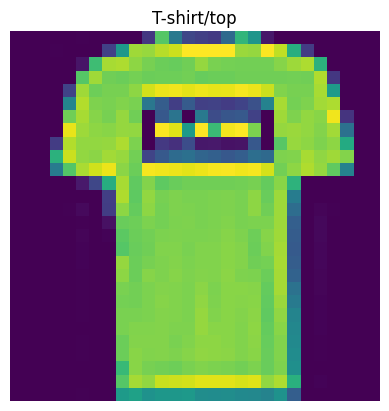

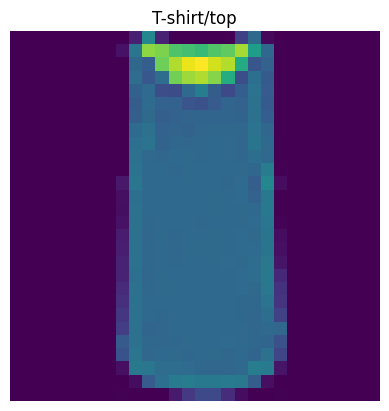

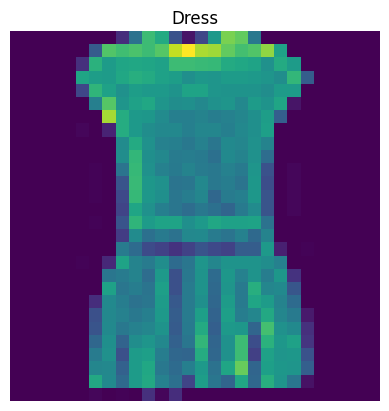

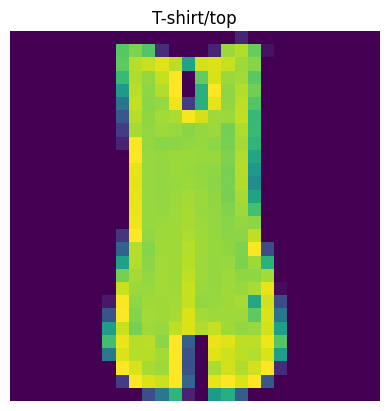

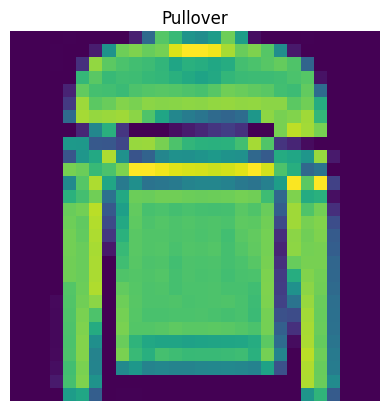

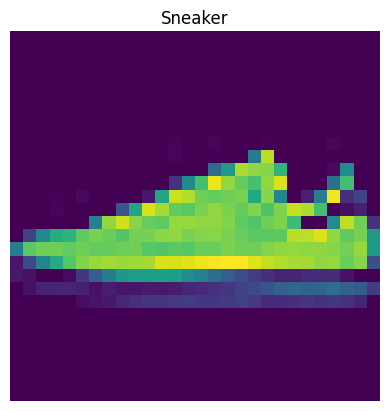

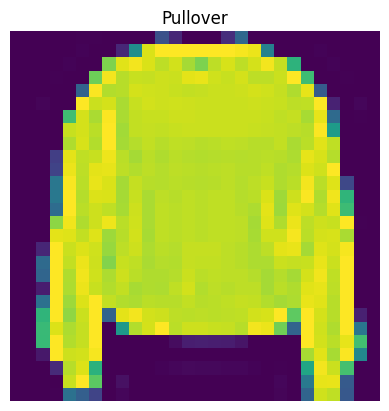

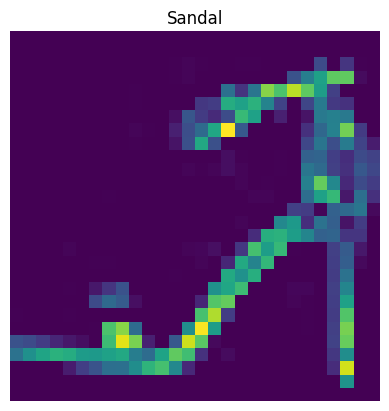

In [7]:
for i, item in enumerate(train):
  if i>8:
    break
  img, title = item
  plot_object(img, title)

In [18]:
train_dataloader = DataLoader(dataset = train,
                        batch_size = 32,
                        shuffle = True)
test_dataloader = DataLoader(dataset = test,
                        batch_size = 32)
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [29]:
class TinyVGG(nn.Module):
  def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
    super().__init__()
    self.phase_1 = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size = 3,
                  stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3,
                  stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.phase_2 = nn.Sequential(
        nn.Conv2d(hidden_channels, hidden_channels,
                  kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels,
                  kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.phase_3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_channels*49, out_channels)
    )
  def forward(self, x):
    x = self.phase_1(x)
    x = self.phase_2(x)
    x = self.phase_3(x)
    return x

In [30]:
model = TinyVGG(1, 10, NUM_OF_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=NUM_OF_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
epochs = 5

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,
                                 y_pred.argmax(dim=1)) # Go from logits -> pred labels
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,
                                    test_pred.argmax(dim=1)) # Go from logits -> pred labels
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [31]:
for epoch in tqdm(range(epochs)):
  train_step(data_loader = train_dataloader,
             model = model,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn= acc_fn,
             device = device)
  test_step(data_loader = test_dataloader,
             model = model,
             loss_fn = loss_fn,
             accuracy_fn= acc_fn,
             device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.52136 | Train accuracy: 0.81%


 20%|██        | 1/5 [00:15<01:01, 15.43s/it]

Test loss: 0.37884 | Test accuracy: 0.86%

Train loss: 0.33770 | Train accuracy: 0.88%


 40%|████      | 2/5 [00:29<00:44, 14.74s/it]

Test loss: 0.33866 | Test accuracy: 0.87%

Train loss: 0.30644 | Train accuracy: 0.89%


 60%|██████    | 3/5 [00:44<00:29, 14.78s/it]

Test loss: 0.33051 | Test accuracy: 0.88%

Train loss: 0.28780 | Train accuracy: 0.90%


 80%|████████  | 4/5 [00:58<00:14, 14.52s/it]

Test loss: 0.32799 | Test accuracy: 0.88%

Train loss: 0.27617 | Train accuracy: 0.90%


100%|██████████| 5/5 [01:12<00:00, 14.56s/it]

Test loss: 0.29998 | Test accuracy: 0.89%



In [33]:
# Confusion Matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [39]:
# Saving the results
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 313/313 [00:02<00:00, 119.49it/s]


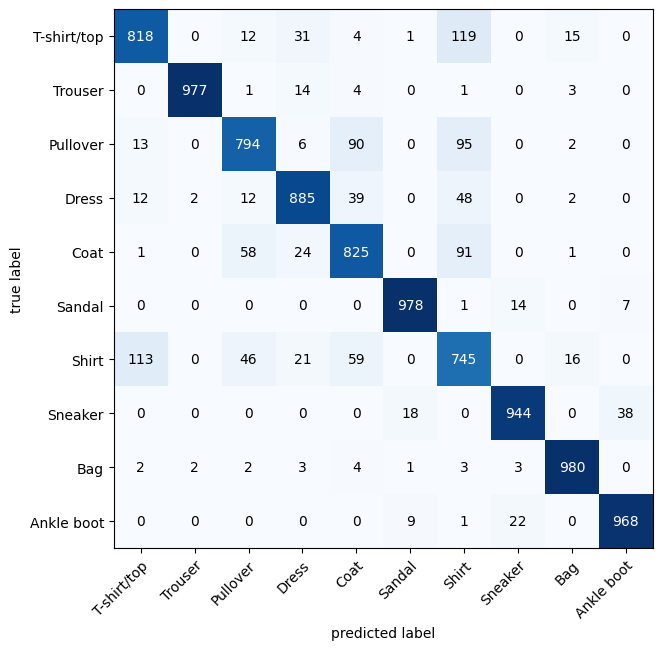

In [44]:
confmatrix = ConfusionMatrix(num_classes=len(features), task='multiclass')
confmatrix_tensor = confmatrix(preds=y_pred_tensor,
                         target=test.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmatrix_tensor.numpy(),
    class_names=features,
    figsize=(10, 7),
)